# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we use a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
This data was used to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


with open('ultimate_data_challenge.json', 'r') as file:
    data = json.load(file)

In [3]:
df = pd.DataFrame(data)

In [4]:
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
# Convert columns
df['signup_date'] = pd.to_datetime(df['signup_date'], errors='coerce')
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], errors='coerce')
#df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

In [7]:
# Handle missing values
df['phone'] = df['phone'].fillna(df['phone'].mode()[0])
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean().round(1))
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean().round(1))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [9]:
df.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000,50000.000000,50000.000000,50000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,2014-01-16 13:04:20.352000,4.601306,1.074764,2014-04-19 08:02:04.992000256,8.849536,60.926084,5.796827,4.778246
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2014-01-09 00:00:00,4.500000,1.000000,2014-02-14 00:00:00,0.000000,33.300000,2.420000,4.700000
50%,1.000000,2014-01-17 00:00:00,4.700000,1.000000,2014-05-08 00:00:00,0.000000,66.700000,3.880000,5.000000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,100.000000,6.940000,5.000000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000
std,3.792684,NaN,0.564977,0.222336,NaN,19.958811,37.081503,5.707357,0.445755


In [10]:
latest_date = df['last_trip_date'].max()
latest_date

Timestamp('2014-07-01 00:00:00')

In [11]:
retained_date = latest_date - pd.Timedelta(days=30)
retained_date

Timestamp('2014-06-01 00:00:00')

In [48]:
# Define retention
df['retained'] = (df['last_trip_date'] >= retained_date).astype(int)
total_entries = len(df)
print("Fraction retained:", df['retained'].sum() / total_entries)

Fraction retained: 0.37608


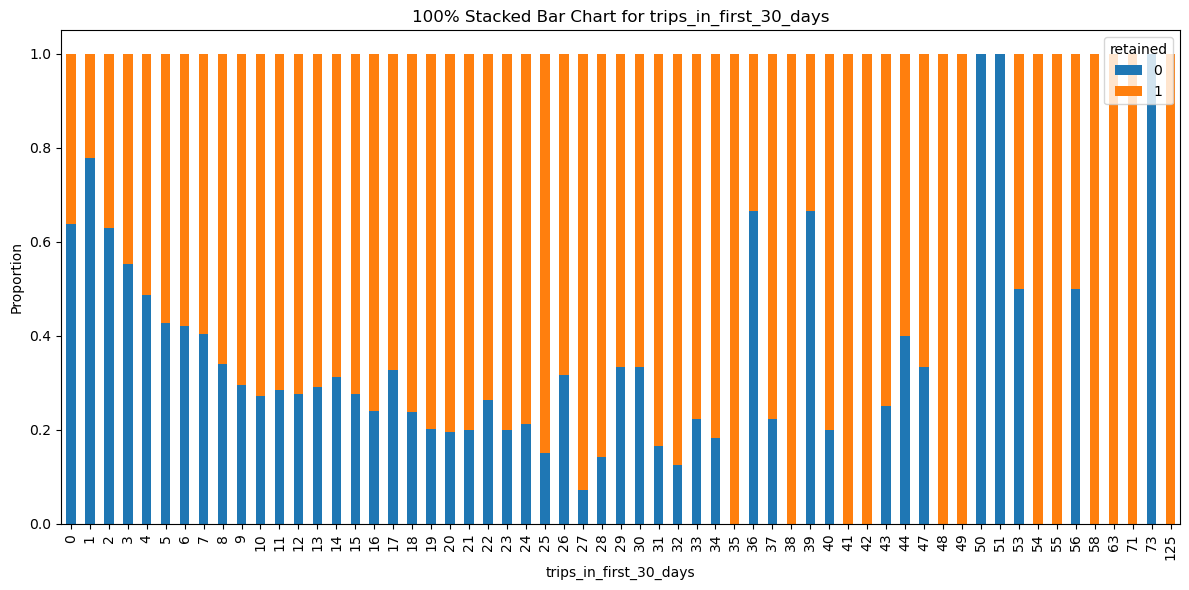

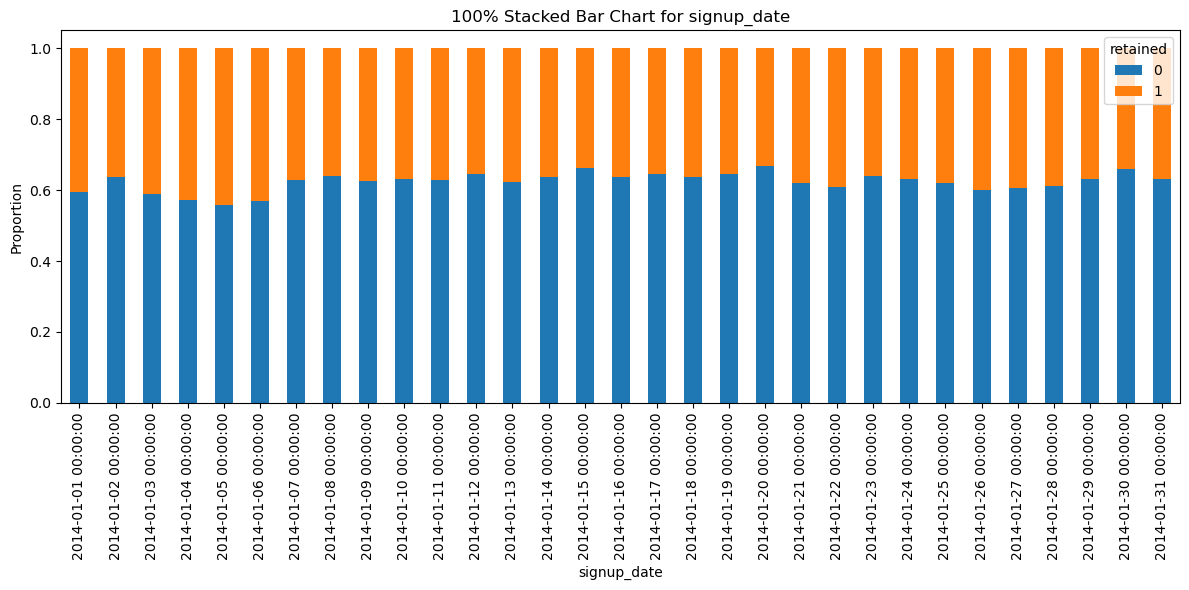

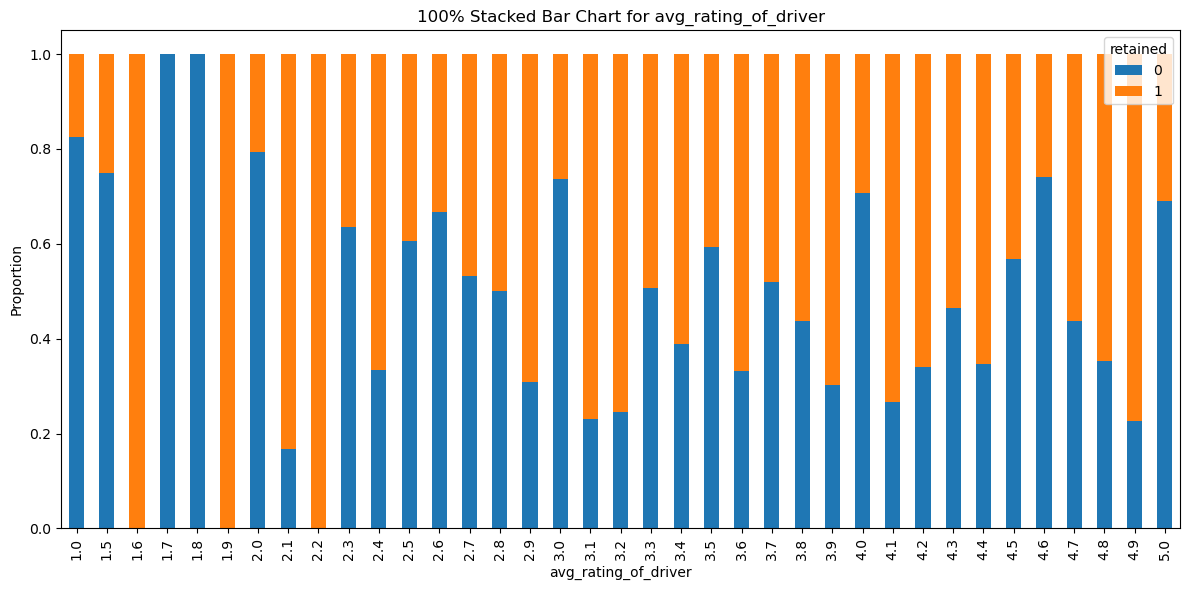

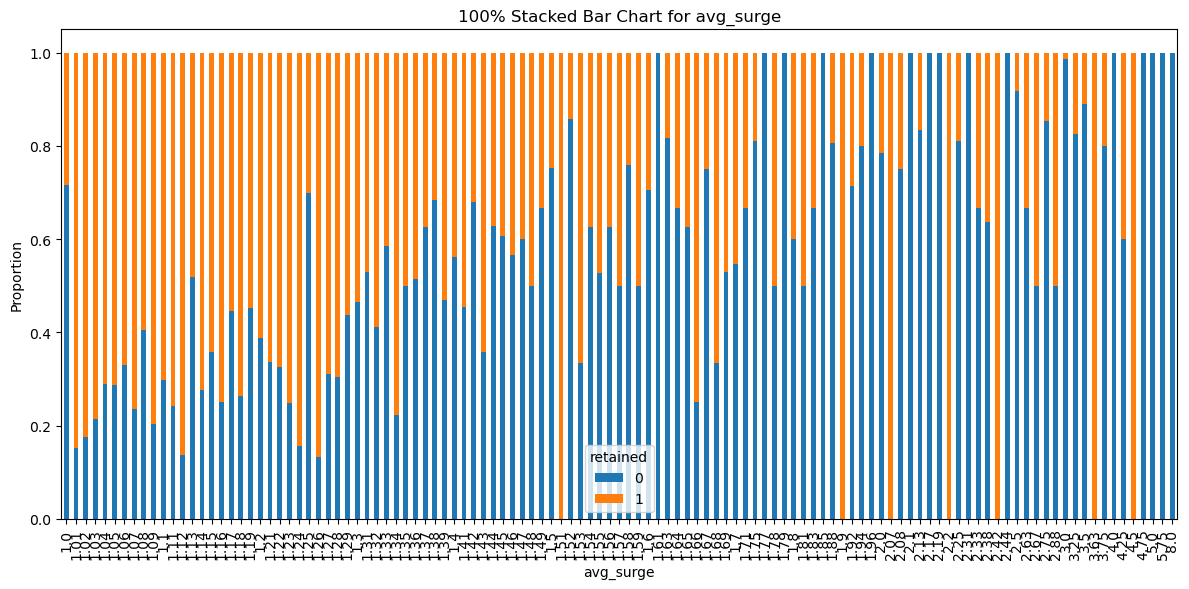

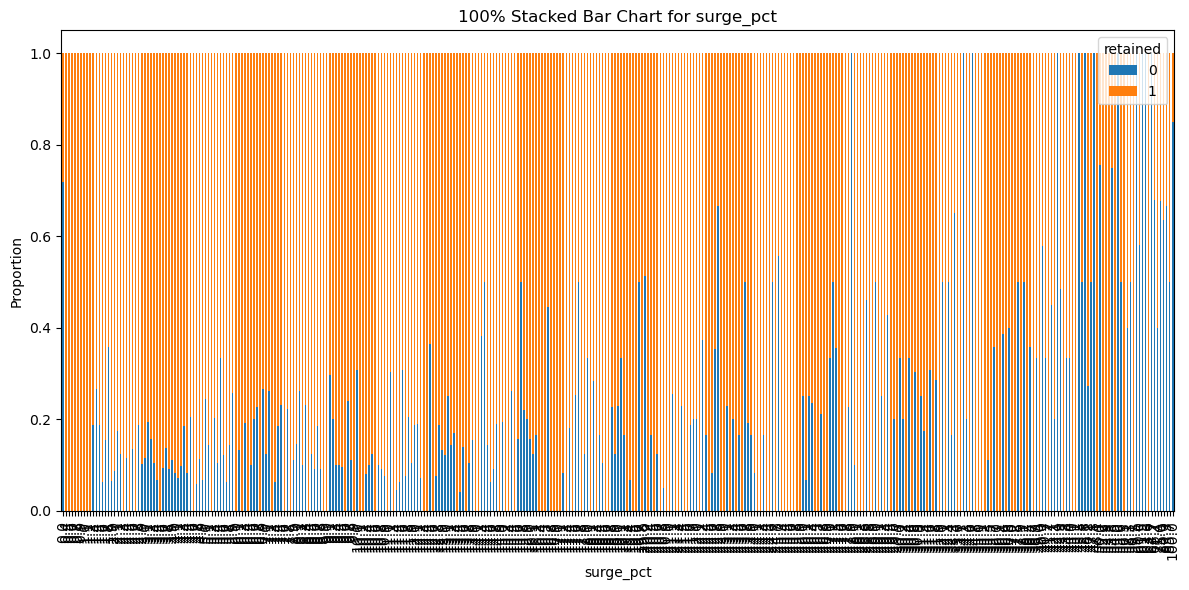

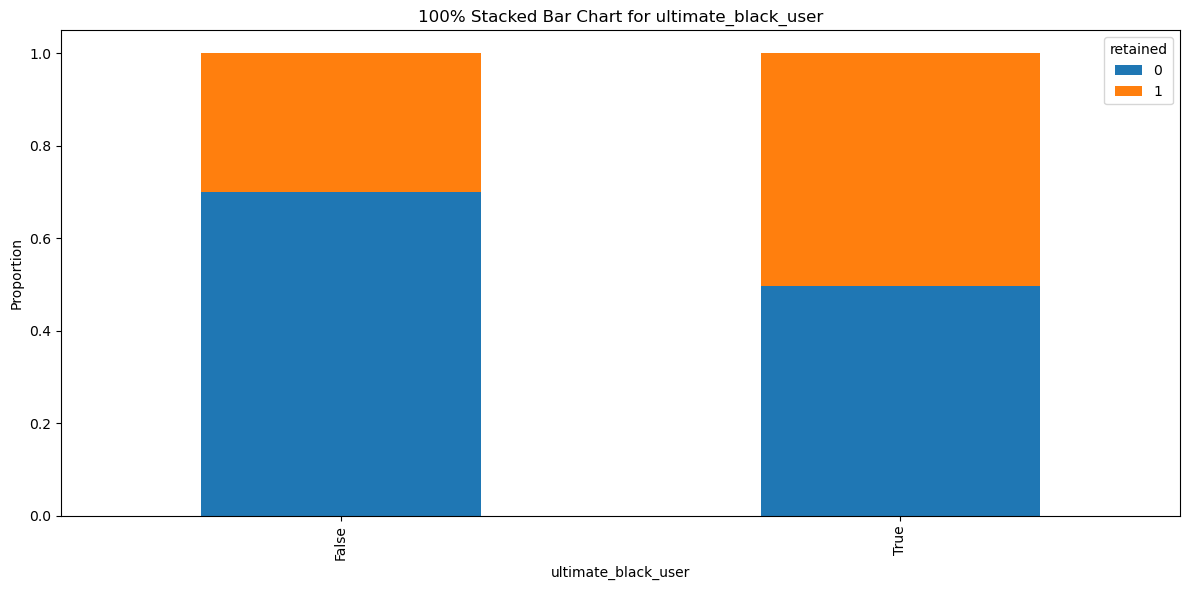

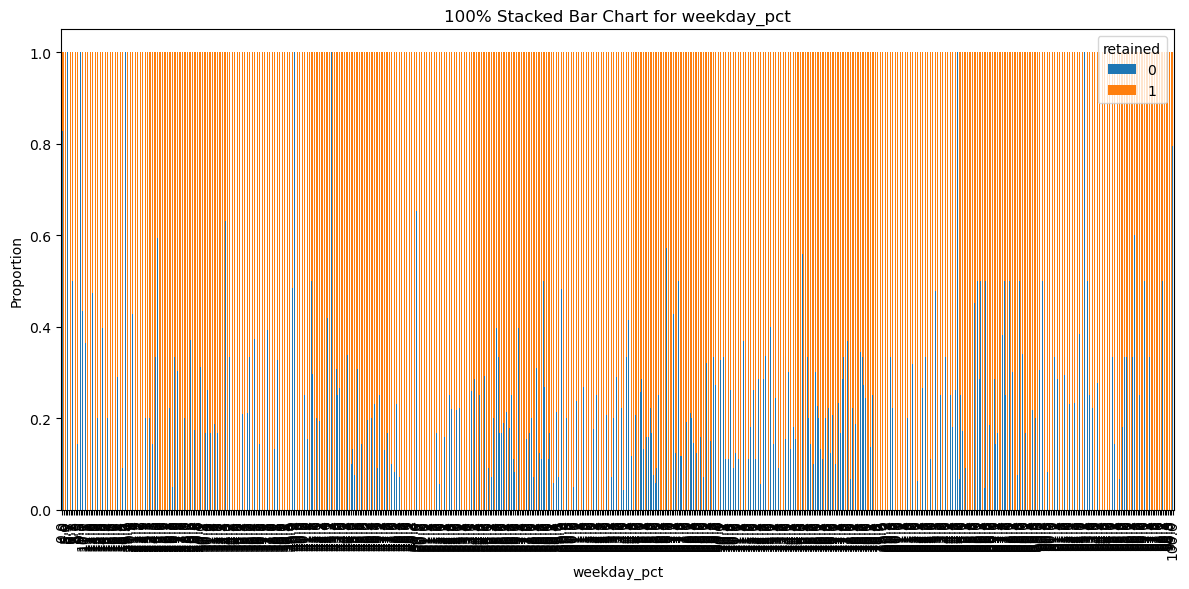

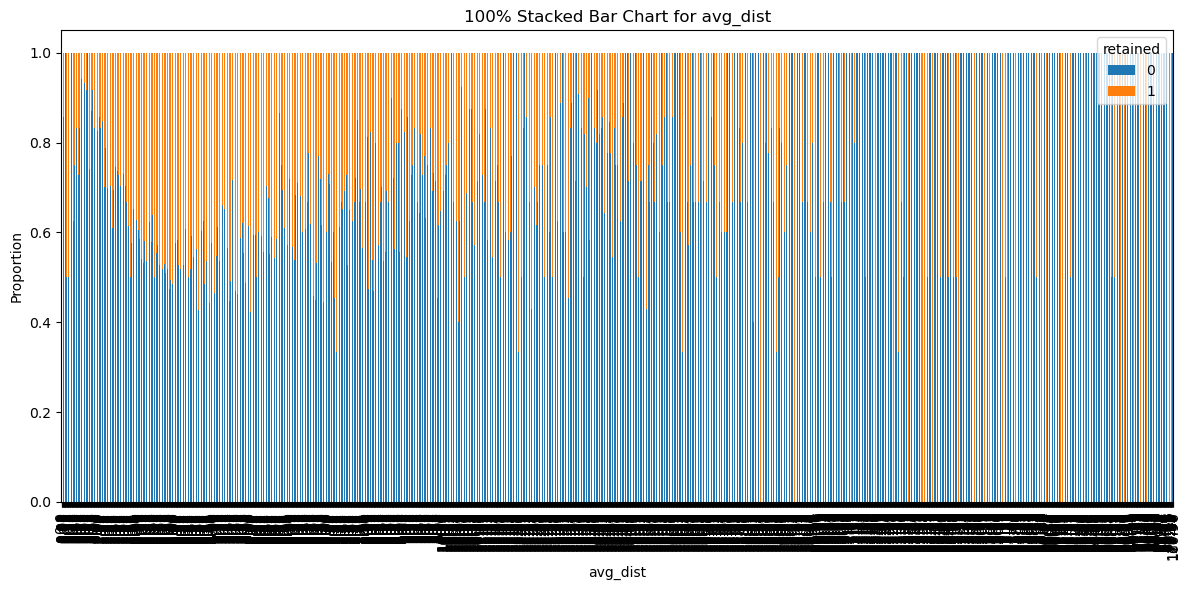

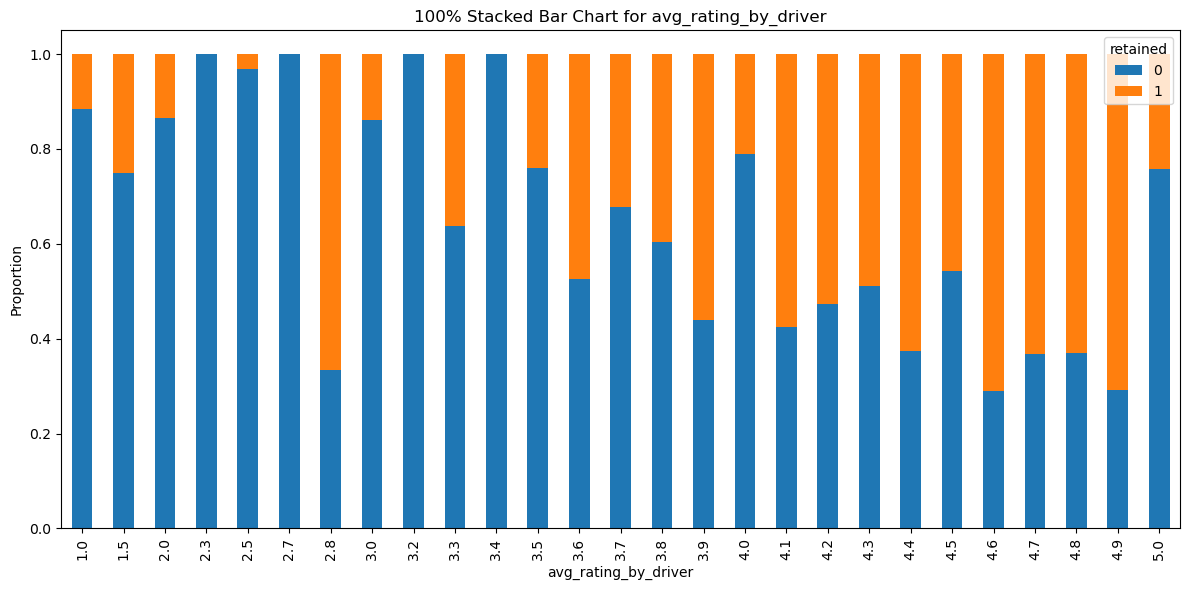

In [13]:
# Function to plot 100% stacked bar chart
def plot_stacked_bar(df, column):
    grouped = df.groupby([column, 'retained']).size().unstack(fill_value=0)
    proportions = grouped.div(grouped.sum(axis=1), axis=0)
    fig, ax = plt.subplots(figsize=(12, 6))  # Set figure size here
    proportions.plot(kind='bar', stacked=True, ax=ax)
    plt.title(f'100% Stacked Bar Chart for {column}')
    plt.ylabel('Proportion')
    plt.xlabel(column)
    plt.tight_layout()
    plt.show()

# List of columns to plot
columns = ['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
           'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'phone_iPhone']

# Loop through each column and plot
for col in columns:
    if col in df.columns:
        plot_stacked_bar(df, col)


In [14]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

# Prepare features and target
X = df.drop(['retained', 'signup_date', 'last_trip_date'], axis=1)
y = df['retained']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
log_prob = log_model.predict_proba(X_test)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, log_pred))
print("ROC AUC:", roc_auc_score(y_test, log_prob))
print("Classification Report:\n", classification_report(y_test, log_pred))

print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("ROC AUC:", roc_auc_score(y_test, rf_prob))
print("Classification Report:\n", classification_report(y_test, rf_pred))

Logistic Regression:
Accuracy: 0.7163
ROC AUC: 0.7532235303663829
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79      6239
           1       0.67      0.49      0.57      3761

    accuracy                           0.72     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.71      0.72      0.71     10000


Random Forest:
Accuracy: 0.7589
ROC AUC: 0.8251749774631271
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81      6239
           1       0.69      0.66      0.67      3761

    accuracy                           0.76     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.76      0.76      0.76     10000



## Conclusion:
The goal was to predict user activity in their sixth month on Ultimate using machine learning. One-hot encoding was used for categorical features and training was done with both Logistic Regression and Random Forest models. Random Forest was the better model, with 0.759 accuracy and 0.825 ROC AUC, with strong recall for identifying likely churn users at 0.82. This makes it a promising tool for churn-prevention understanding, as it effectively distinguishes between retained and inactive users.

Ultimate can use the model’s insights to identify key patterns like low trip counts in the first 30 days, low average driver ratings, or high surge pricing exposure. By targeting users who show these patterns can increase the likelihood of retaining them. Additionally, understanding which cities or phone platforms show higher churn could help refine regional strategies or app experiences.
